In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [85]:
INPUT='/mnt/c/Users/scl38887/Documents/git/aldehyde/results/dyntrans_full_3H_ws/integrated_comp/stats.csv'
OUTPUT='/mnt/c/Users/scl38887/Documents/git/aldehyde/results/graphics_general' #fix_co2/graphics/integrated_comp/'

In [86]:
def prepare_data(data, plottype, zerofilter=False):
    # Prepare the data
    # Extract the Co2L which is in position 5-8
    data["opts"] = data["opts"].str[4:]

    # Rescale the cost from euro to B€
    data["cost"] = data["cost"] / 1e9

    # Round the data
    to_round = plottype
    data[to_round] = data[to_round].round(2)

    # Filter the data to remove 0 export and 0 co2 reduction
    print(f"zerofiler is set to {zerofilter} or in boolean {bool(zerofilter)}")
    if zerofilter:
        print("Filtering data")
        #data = data[(data["h2export"] != 0) & (data["opts"] != "2.0")]
        data = data[(data["h2export"] != 0)]

    else:
        pass

    return data


In [87]:
def reshape_data(data, opts, h2export, plottype):
    # Reshape the data for all columns in to_round and save it in data dictionary
    data_reshaped = {}
    # TODO loop is not necessary since I only use one plottype
    for i in [plottype]:
        data_reshaped[i] = data[i].values.reshape(len(opts), len(h2export)).T

    return data_reshaped

In [88]:
def plot_data(data_reshaped, plottype, levels, show_minimums, el_base_demand, label):
    # Turn "limit" to "reduction" (e.g. Co2L0.90 means 10% reduction)
    opts_reverse = 1 - opts
    opts_reverse[opts_reverse < 0] = 0

    # Plot a contour plot of the data having the y-axis the column "h2export", x-axis the column "sopts", and the z-axis the column "cost"
    fig = plt.figure(figsize=(9, 6))
    contour = plt.contourf(
        opts_reverse * 100,
        h2export,
        np.flip(data_reshaped[plottype], axis=1),
        levels=levels,
    )
    if show_minimums == True:
        # Return the position where the minimum of data_reshaped[plottype] is
        minpos = np.argmin(data_reshaped[plottype], axis=0)

        # Plot the minimum value as a black dot
        plt.plot(
            opts_reverse[::-1] * 100,
            h2export[minpos],
            "ko",
            markersize=4,
            label="min.",
            alpha=0.5,
        )

        # Plot approximation/regression with np.polyfit of the minimum value as line
        polydegree = 4
        line =  np.poly1d(np.polyfit(opts_reverse * 100, h2export[minpos], polydegree))(
                np.linspace(min(opts_reverse), max(opts_reverse), 100) * 100)
        # Limit line to h2 export boundaries
        line[line < min(h2export)] = min(h2export)
        line[line > max(h2export)] = max(h2export)

        plt.plot(
            # opts_reverse[::-1] * 100,
            np.linspace(min(opts_reverse), max(opts_reverse), 100)[::-1] * 100,
            line,
            # "k--",
            color="black",
            label="min. approx.",
            alpha=0.5,
        )
        plt.legend()

    plt.xlabel("CO$_2$ Reduction in % of base levels")
    plt.ylabel("Hydrogen Export Volume in TWh")
    plt.colorbar(pad=0.14).set_label(label)

    ax2 = plt.gca().twinx()
    h2export_secondary = h2export / el_base_demand
    ax2.set_ylabel("H2-Exp/El-base-demand")
    ax2.set_ylim(0, max(h2export_secondary))  # Adjust the limit based on your data


    # Save the plot
    plt.savefig(OUTPUT+"contour_sub.pdf", bbox_inches="tight")

    plt.show()

    # Set negative values in array df to 0
    # df[df < 0] = 0

    return

In [91]:
# Prepare the data
plottype = "mg_H2_False_False_exportonly"
levels = 20
show_minimums = False
label = "Cost in B€"
zerofilter = True

data = pd.read_csv(INPUT)
data = prepare_data(data, zerofilter=zerofilter, plottype=plottype)
h2export = np.unique(data["h2export"])
opts = np.unique(
    data["opts"].fillna(100).astype(float)
)  # TODO improve the fillna value
el_base_demand = min(reshape_data(data, opts, h2export, plottype="el_base_demand")["el_base_demand"][0])
data_reshaped = reshape_data(data, opts, h2export, plottype=plottype)


zerofiler is set to True or in boolean True
Filtering data


Plot data

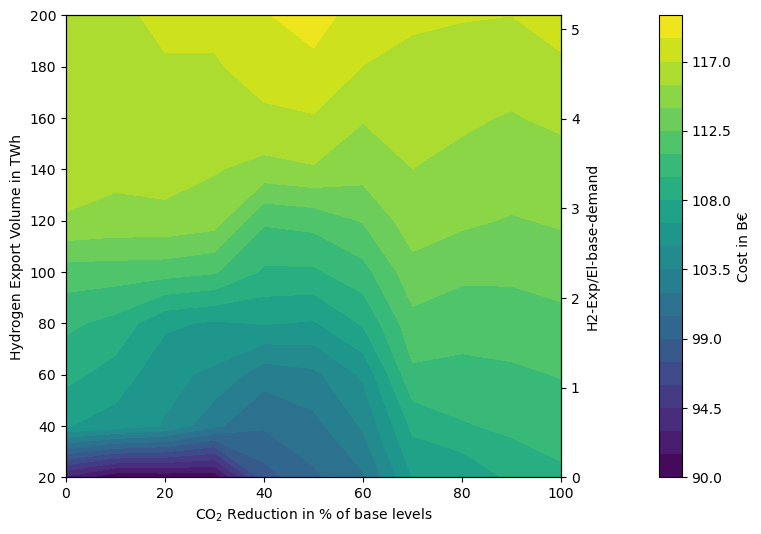

In [92]:
plot_data(data_reshaped, plottype, levels, show_minimums=show_minimums, el_base_demand=el_base_demand, label=label)